In [1]:
import pyro
import math
import torch
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import ExitStack
from functools import partial
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

from causal_pyro.dynamical.handlers import (
    PointIntervention,
    DynamicIntervention,
    SimulatorEventLoop,
    simulate,
    ODEDynamics
)

from causal_pyro.dynamical.handlers import NonInterruptingPointObservationArray

# from causal_pyro.dynamical.handlers import NonInterruptingPointObservation as PointObservation

from causal_pyro.dynamical.ops import State

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

In [2]:
# # THIS WILL BE REPLACED
from typing import  Dict
# from pyro.poutine.runtime import _PYRO_STACK

# class TrajectoryObservation(pyro.poutine.messenger.Messenger):
#     def __init__(
#         self,
#         data: Dict[float, Dict[str, torch.Tensor]],
#         eps: float = 1e-6,
#     ):
#         self.observation_managers = []
#         for obs_time, obs_state in data.items():
#             self.observation_managers.append(PointObservation(obs_time, obs_state, eps=eps))

#     def __enter__(self):
#         for manager in self.observation_managers:
#             manager.__enter__()
        
#     def __exit__(self, exc_type, exc_value, traceback):
#         for __ in self.observation_managers:
#             _PYRO_STACK.pop() # remove the observation manager from the stack (not safe but this handler will be replaced shortly)
#             # manager.__exit__(exc_type, exc_value, traceback) # creates an error because last element on stack isn't self


class TrajectoryObservation(pyro.poutine.messenger.Messenger):
    def __init__(
            self,
            data: Dict[float, Dict[str, torch.Tensor]],
            eps: float = 1e-6,
    ):
        times = torch.tensor([t for t, _ in data.items()])
        data_obs_dicts = [s for _, s in data.items()]
        # data_obs_dicts is a list of dictionaries, each of which contains the observations at a single time point
        #  these need to be concatenated into a single array valued dictionary.
        data_obs = dict()
        for key in data_obs_dicts[0].keys():
            data_obs[key] = torch.stack([d[key] for d in data_obs_dicts])

        self.nipoa = NonInterruptingPointObservationArray(times, data_obs, eps=eps)

    def __enter__(self):
        self.nipoa.__enter__()

    def __exit__(self, *args, **kwargs):
        self.nipoa.__exit__(*args, **kwargs)


In [3]:
class SimpleSIRDynamics(ODEDynamics):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        dX.S = -self.beta * X.S * X.I
        dX.I = self.beta * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    # TODO: the observation model should probably be a truncated poisson. Basically, you systematically undercount the number of infected people
    # and recovered people since not everyone reports 
    def observation(self, X: State[torch.Tensor]):
        test_kit_sales = torch.relu(pyro.sample("test_kit_sales", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample("I_obs", dist.Poisson(X.I))# noisy number of infected actually observed
        R_obs = pyro.sample("R_obs", dist.Poisson(X.R)) # noisy number of recovered actually observed
        return {"test_kit_sales": test_kit_sales, "I_obs": I_obs, "R_obs": R_obs}

# Generate synthetic data from an SIR model

In [4]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.))
time_period = torch.linspace(0, 3, steps=21)

# We now simulate from the SIR model
beta_true = torch.tensor(0.05)
gamma_true =  torch.tensor(0.5)
sir_true = SimpleSIRDynamics(beta_true, gamma_true)
sir_true_traj = simulate(sir_true, init_state, time_period)

### Plot the simulated trajectories from SIR model

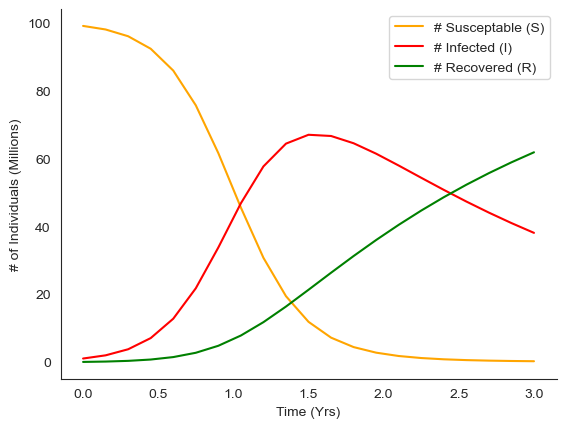

In [5]:
sns.lineplot(x=time_period, y=sir_true_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_true_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_true_traj.R, label="# Recovered (R)", color='green')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Sample observed data from the model
 

In [6]:
obs_time_period = torch.arange(1/52, 1.01, 1/52) # collect data every week for the past 6mo
N_obs = obs_time_period.shape[0]
sir_obs_traj = simulate(sir_true, init_state, obs_time_period)
data = dict()
for time_ix in range(N_obs):
    data[obs_time_period[time_ix].item()] = sir_true.observation(sir_obs_traj[time_ix])

In [7]:
test_kit_sales = torch.stack([data[time.item()]["test_kit_sales"] for time in obs_time_period])
I_obs = torch.stack([data[time.item()]["I_obs"] for time in obs_time_period])
R_obs = torch.stack([data[time.item()]["R_obs"] for time in obs_time_period])

Text(0, 0.5, 'Observed # Recovered (Millions)')

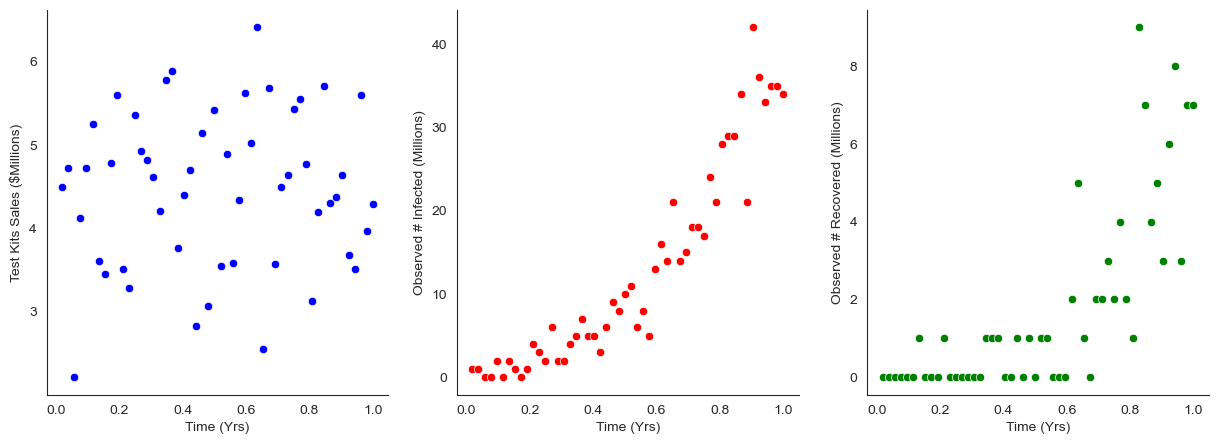

In [11]:
# TODO: actual trend

# Plot observed data
fix, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.scatterplot(x=obs_time_period, y=test_kit_sales, color='blue', ax=ax[0])
sns.despine()
ax[0].set_xlabel("Time (Yrs)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.scatterplot(x=obs_time_period, y=I_obs, color='red', ax=ax[1])
sns.despine()
ax[1].set_xlabel("Time (Yrs)")
ax[1].set_ylabel("Observed # Infected (Millions)")

# Plot observed recovered
sns.scatterplot(x=obs_time_period, y=R_obs, color='green', ax=ax[2])
sns.despine()
ax[2].set_xlabel("Time (Yrs)")
ax[2].set_ylabel("Observed # Recovered (Millions)")

# Perform Inference!

In [12]:
# We place uniform priors on the beta and gamma parameters defining the SIR model 
def model():
    beta = pyro.sample("beta", dist.Uniform(0, 1))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = SimpleSIRDynamics(beta, gamma)
    return sir


def unconditional_sir_model(data, init_state, tspan):
    sir = model()
    return simulate(sir, init_state, tspan)


def conditioned_sir(data, init_state, tspan):
    sir = model()
    with SimulatorEventLoop():
        with TrajectoryObservation(data):
            traj = simulate(sir, init_state, tspan)
    return traj

In [13]:
guide = AutoMultivariateNormal(conditioned_sir)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(conditioned_sir, guide, adam, loss=Trace_ELBO())
n_steps = 100

# Do gradient steps
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(data, init_state, torch.tensor([0., 3.])) # need tspan to contain all observation times
    print("[iteration %04d] loss: %.4f" % (step + 1, loss / N_obs))
    guide_median = guide.median()
    print("beta post. median est: %.4f, gamma post. median est: %.4f" % (guide_median['beta'].item(), guide_median['gamma'].item()))
        

[iteration 0001] loss: 73.7273
beta post. median est: 0.7390, gamma post. median est: 0.4665
[iteration 0002] loss: 73.4740
beta post. median est: 0.7332, gamma post. median est: 0.4590
[iteration 0003] loss: 73.5426
beta post. median est: 0.7273, gamma post. median est: 0.4516
[iteration 0004] loss: 72.8230
beta post. median est: 0.7212, gamma post. median est: 0.4443
[iteration 0005] loss: 73.1132
beta post. median est: 0.7151, gamma post. median est: 0.4369
[iteration 0006] loss: 73.2740
beta post. median est: 0.7089, gamma post. median est: 0.4296
[iteration 0007] loss: 73.2235
beta post. median est: 0.7026, gamma post. median est: 0.4223
[iteration 0008] loss: 73.0166
beta post. median est: 0.6963, gamma post. median est: 0.4151
[iteration 0009] loss: 73.0000
beta post. median est: 0.6898, gamma post. median est: 0.4079
[iteration 0010] loss: 72.1731
beta post. median est: 0.6832, gamma post. median est: 0.4007
[iteration 0011] loss: 73.3159
beta post. median est: 0.6766, gamma po

# Evaluate the performance of our inference

In [14]:
# Generate samples from the posterior predictive distribution
predictive = Predictive(unconditional_sir_model, guide=guide, num_samples=100)
samples = predictive(data, init_state, torch.tensor([0., .01])) # just trying to get beta and gamma samples

### First, we compare the approximate posterior distribution with the true beta and gamma parameters generating the data

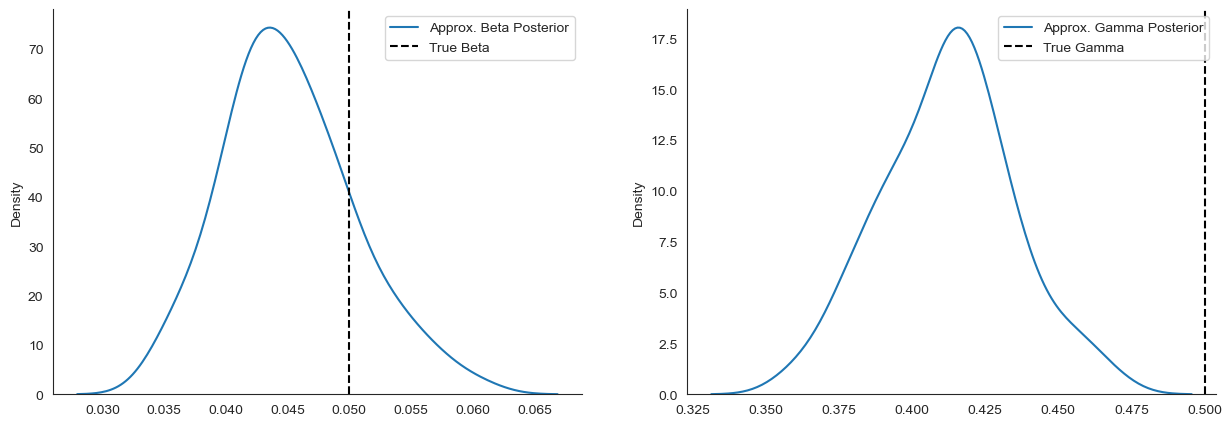

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(samples['beta'], label='Approx. Beta Posterior', ax=ax[0])
ax[0].axvline(beta_true, color='black', label='True Beta', linestyle='--')
sns.despine()
ax[0].legend(loc='upper right')

sns.kdeplot(samples['gamma'], label='Approx. Gamma Posterior', ax=ax[1])
plt.axvline(gamma_true, color='black', label='True Gamma', linestyle='--')
sns.despine()
ax[1].legend(loc='upper right')

### Next, we compare the predictive performance on the held at period between $t=.5$ and $t=3$ years

In [16]:
# TODO: we should add functionality so that pyro Predictive gives use predictions of sites in `observation` method...

S_pred = []
I_pred = []
R_pred = []

for beta, gamma in zip(samples['beta'], samples['gamma']):
    sir = SimpleSIRDynamics(beta, gamma)
    sir_traj = simulate(sir, init_state, time_period)
    S_pred.append(sir_traj.S)
    I_pred.append(sir_traj.I)
    R_pred.append(sir_traj.R)

# Reshape as a tensor of postior samples x time matrix
S_pred = torch.stack(S_pred)
I_pred = torch.stack(I_pred)
R_pred = torch.stack(R_pred)

In [17]:
def SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax):
    sns.lineplot(x=time_period, y=state_pred.mean(dim=0), color=color, label="Posterior Mean", ax=ax)
    # 90% Credible Interval
    ax.fill_between(time_period, torch.quantile(state_pred, 0.05, dim=0), torch.quantile(state_pred, 0.95, dim=0), alpha=0.2, color=color)
    
    ax.set_xlabel("Time (Yrs)")
    ax.set_ylabel(ylabel)

def SIR_data_plot(time_period, data, data_label, ax):
    sns.lineplot(x=time_period, y=data, color='black', ax=ax, linestyle='--', label=data_label)

def SIR_test_plot(test_time, ax):
    ax.axvline(test_time, color='black', linestyle='dotted', label='Start of Testing Period')

def SIR_plot(time_period, test_time, state_pred, data, ylabel, color, data_label, ax, legend=False):
    SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax)
    SIR_data_plot(time_period, data, data_label, ax)
    SIR_test_plot(test_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    sns.despine()

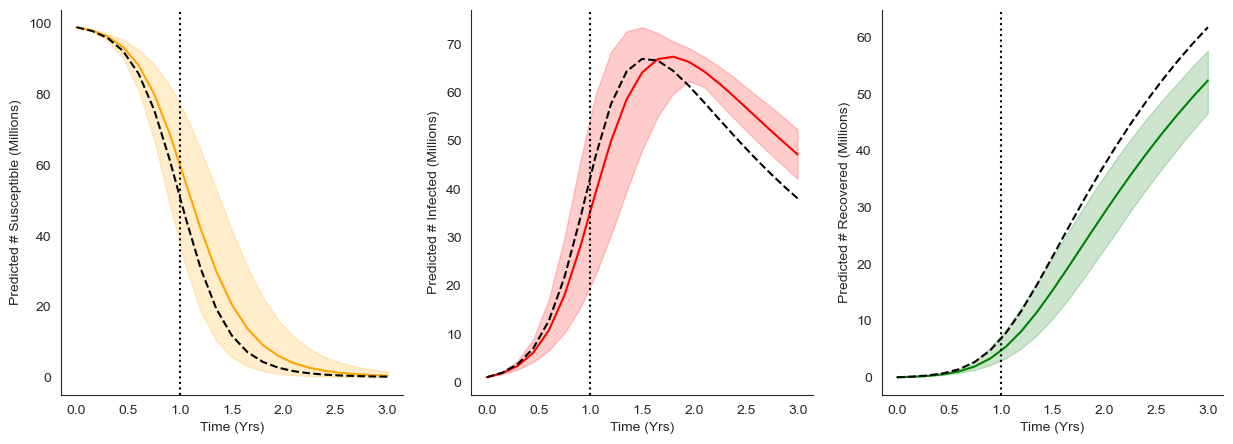

In [18]:
# Plot predicted values for S, I, and R with uncertainty bands (+/- 2 std. devs.)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(time_period, 1, S_pred, sir_true_traj.S, "Predicted # Susceptible (Millions)", "orange", "Actual # Susceptible", ax[0])
SIR_plot(time_period, 1, I_pred, sir_true_traj.I, "Predicted # Infected (Millions)", "red", "Actual # Infected", ax[1])
SIR_plot(time_period, 1, R_pred, sir_true_traj.R, "Predicted # Recovered (Millions)", "green", "Actual # Recovered", ax[2])

## Supppose the healthcare system capacity is only 50 million infected people. Let's explore how different interventions might flatten the infection curve

Suppose the government can enact different lockdown measures (of varying strength) to flatten the infection curve. The goal is the select a lockdown measure so that the number of infected individuals is less than 50 million at any point in time.

Following [2], we define the stength of lockdown measure at time $t$ by $l_t \in [0, 1]$ for $1 \leq t \leq T$. Parametrize the transmission rate $\beta_t$ as:

\begin{equation*}
    \beta_t = (1 - l_t) \beta_0,
\end{equation*}

where $\beta_0$ denotes the unmitigated transmission rate and larger values of $l_t$ correspond to stronger lockdown measures. Then, the time-varying SIR model is defined as follows:

\begin{equation*}
    \begin{split}
        dS_t &= -\beta_t S_t I_t \\
        dI_t &= \beta_t S_t I_t - \gamma I_t \\
        dR_t &= \gamma I_t
    \end{split}
\end{equation*}

where $S_t, I_t, R_t$ denote the number of susceptable, infected, and recovered individuals at time $t$ for $1 \leq t \leq T$.

In [19]:
# TODO: re-write first one so that the class below can just inherit from it
class SimpleSIRDynamicsIntervenable(ODEDynamics):
    def __init__(self, beta0, gamma):
        super().__init__()
        self.beta0 = beta0
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        beta_t = (1 - X.l) * self.beta0 # time-varing beta parametrized by lockdown strength l_t
        dX.l = torch.tensor(0.)
        dX.S = -beta_t * X.S * X.I
        dX.I = beta_t * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    def observation(self, X: State[torch.Tensor]):
        S = pyro.deterministic("S", X.S)
        I = pyro.deterministic("I", X.I)
        R = pyro.deterministic("R", X.R)
        test_kit_sales = torch.relu(pyro.sample("test_kit_sales", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample("I_obs", dist.Poisson(X.I)) # noisy number of infected actually observed
        R_obs = pyro.sample("R_obs", dist.Poisson(X.R)) # noisy number of recovered actually observed
        return {"test_kit_sales": test_kit_sales, "I_obs": I_obs, "R_obs": R_obs, "S": S, "I": I, "R": R}

init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.), l=torch.tensor(0.))

In [20]:
def intervened_sir(lockdown_policy, init_state, tspan, beta_true=None, gamma_true=None):
    if beta_true is not None and gamma_true is not None:
        sir = SimpleSIRDynamicsIntervenable(beta_true, gamma_true)
    else:
        beta0 = pyro.sample("beta0", dist.Uniform(0, 1))
        gamma = pyro.sample("gamma", dist.Uniform(0, 1))
        sir = SimpleSIRDynamicsIntervenable(beta0, gamma)
    intervene_managers = []
    for time, strength in lockdown_policy.items():
        intervene_managers.append(PointIntervention(time=torch.tensor(time), intervention=State(l=strength)))
    with SimulatorEventLoop():
        with ExitStack() as stack:
            for manager in intervene_managers:
                stack.enter_context(manager)
            traj = simulate(sir, init_state, tspan)
    return traj

### Let's first look at a deterministic intervention where the transmission rate is reduced by 75% between $t=1$ and $t=2$ due to stronger lockdown measures. We see in the figure below that this lockdown measures indeed "flattens" the curve.

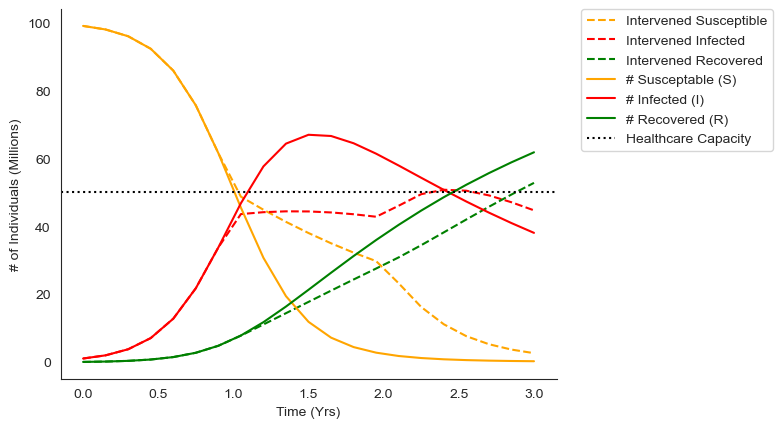

In [21]:
lockdown_policy = dict()
lockdown_policy[1.01] = torch.tensor(.75) 
lockdown_policy[2] = torch.tensor(0.) # no more lockdowns so transmission rate goes back to normal

sir_intervene_traj = intervened_sir(lockdown_policy, init_state, time_period, beta_true=beta_true, gamma_true=gamma_true)

sns.lineplot(x=time_period, y=sir_intervene_traj.S, label='Intervened Susceptible', linestyle='--', color='orange')
sns.lineplot(x=time_period, y=sir_intervene_traj.I, label='Intervened Infected', linestyle='--', color='red')
sns.lineplot(x=time_period, y=sir_intervene_traj.R, label='Intervened Recovered', linestyle='--', color='green')

sns.lineplot(x=time_period, y=sir_true_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_true_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_true_traj.R, label="# Recovered (R)", color='green')
plt.axhline(50, label='Healthcare Capacity', color='black', linestyle='dotted')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Now imagine the goverment instead does a very strong lockdown measure for only a short 6-month period and the transmission rate is nearly 0. After this 6-month period, suppose all lockdown measures are completely removed. Then, the infection rate curve has two peaks or "waves", where the second wave leads to healthcare capacity issues  

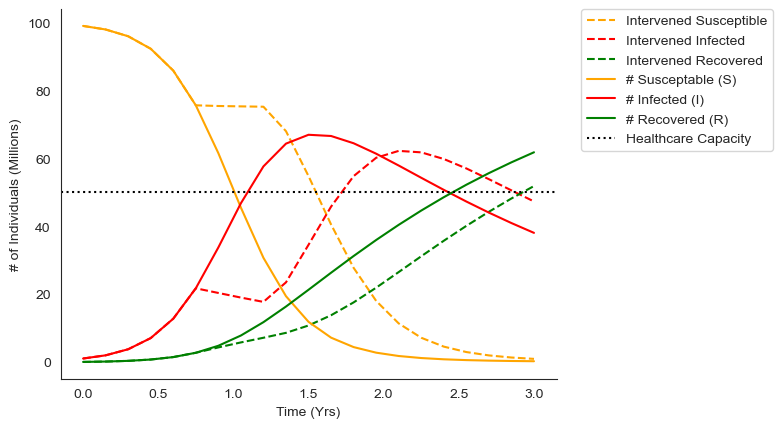

In [22]:
lockdown_policy = dict()
lockdown_policy[.751] = torch.tensor(.99) 
lockdown_policy[1.251] = torch.tensor(.0) # no more lockdowns

sir_intervene_traj = intervened_sir(lockdown_policy, init_state, time_period, beta_true=beta_true, gamma_true=gamma_true)

sns.lineplot(x=time_period, y=sir_intervene_traj.S, label='Intervened Susceptible', linestyle='--', color='orange')
sns.lineplot(x=time_period, y=sir_intervene_traj.I, label='Intervened Infected', linestyle='--', color='red')
sns.lineplot(x=time_period, y=sir_intervene_traj.R, label='Intervened Recovered', linestyle='--', color='green')

sns.lineplot(x=time_period, y=sir_true_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_true_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_true_traj.R, label="# Recovered (R)", color='green')
plt.axhline(50, label='Healthcare Capacity', color='black', linestyle='dotted')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Next, let's consider a state-dependent intervention ("dynamic intervention")

### Here we assume that the government will issue a lockdown measure that reduces the transmission rate by one half whenever the number of infected people hits 10 million

In [23]:
def government_lockdown_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        # ret = target_state.subtract_shared_variables(state).l2()
        return state.I - target_state.I
    return event_f


def government_lift_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        # ret = target_state.subtract_shared_variables(state).l2()
        return target_state.I - state.I
    return event_f


lockdown_trigger = State(I=torch.tensor(10.))
lockdown_strength = State(l=torch.tensor(.5)) # reduces transmission rate by 50%

In [24]:
with SimulatorEventLoop():
    with DynamicIntervention(
        event_f=government_lockdown_policy(lockdown_trigger),
        intervention=lockdown_strength,
        var_order=init_state.var_order,
        max_applications=1,
    ):
        sir_intervene_traj = simulate(SimpleSIRDynamicsIntervenable(beta_true, gamma_true), 
                                      init_state, time_period)


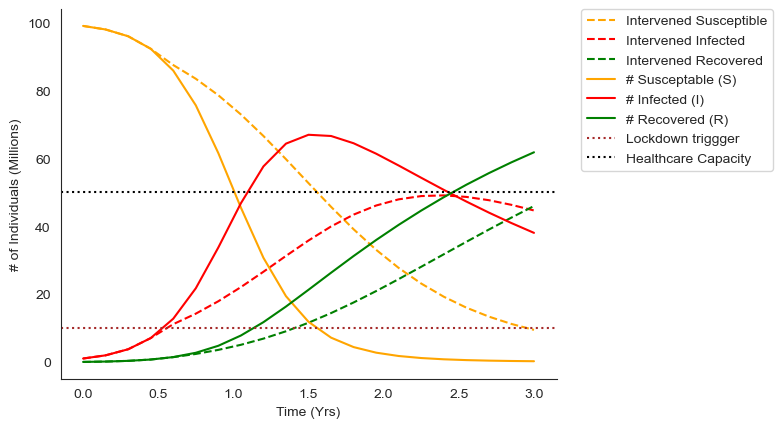

In [25]:
sns.lineplot(x=time_period, y=sir_intervene_traj.S, label='Intervened Susceptible', linestyle='--', color='orange')
sns.lineplot(x=time_period, y=sir_intervene_traj.I, label='Intervened Infected', linestyle='--', color='red')
sns.lineplot(x=time_period, y=sir_intervene_traj.R, label='Intervened Recovered', linestyle='--', color='green')

sns.lineplot(x=time_period, y=sir_true_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_true_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_true_traj.R, label="# Recovered (R)", color='green')
plt.axhline(10, label='Lockdown triggger', color='brown', linestyle='dotted')
plt.axhline(50, label='Healthcare Capacity', color='black', linestyle='dotted')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# 

# Multilevel SIR Model

So far we have assumed we only observe data from one region. Now let's imagine we observe data from $M$ different regions, where region $m$ has transmission rate ($\beta_m$) and recovery rate ($\gamma_m$) for $1 \leq m \leq M$.


Note: we assume there are no interactions between regions (i.e., individuals from one region cannot infect those from another)

In [26]:
class SimpleSIRDynamicsIntervenableNamed(SimpleSIRDynamicsIntervenable):
    def __init__(self, beta0, gamma, name):
        super().__init__(beta0, gamma)
        self.name = name

    def observation(self, X: State[torch.Tensor]):
        test_kit_sales = torch.relu(pyro.sample(f"test_kit_sales_{self.name}", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample(f"I_obs_{self.name}", dist.Poisson(X.I))
        R_obs = pyro.sample(f"R_obs_{self.name}", dist.Poisson(X.R))
        return {f"test_kit_sales_{self.name}": test_kit_sales, f"I_obs_{self.name}": I_obs, f"R_obs_{self.name}": R_obs}


def unit_level_sir(unit_name, beta0_prior=dist.Uniform(0.0, 1.0), gamma_prior=dist.Uniform(0.0, 1.0)):
    beta0 = pyro.sample(f"beta0_{unit_name}", beta0_prior)
    gamma = pyro.sample(f"gamma_{unit_name}", gamma_prior)
    sir = SimpleSIRDynamicsIntervenableNamed(beta0, gamma, unit_name)
    return sir

def multi_level_sir(N_stratum, init_states, tspan, beta_prior=dist.Uniform(0.0, 1.0), gamma_prior=dist.Uniform(0.0, 1.0)):
    solutions = []
    for unit_ix in range(N_stratum):
        sir = unit_level_sir(unit_ix, beta_prior, gamma_prior)
        init_state = init_states[unit_ix]
        with SimulatorEventLoop():
            solution = simulate(sir, init_state, tspan)
        solutions.append(solution)
        [pyro.deterministic(f"{k}_{unit_ix}", getattr(solution,k)) for k in solution.keys]
    return solutions

def conditioned_multi_level_sir(multi_data, init_states, tspan, beta_prior=dist.Uniform(0.0, 1.0), gamma_prior=dist.Uniform(0.0, 1.0)):
    for unit_ix, data in multi_data.items():
        sir = unit_level_sir(unit_ix, beta_prior, gamma_prior)
        init_state = init_states[unit_ix]
        with SimulatorEventLoop():
            if data is None:
                simulate(sir, init_state, tspan)
            else:
                with TrajectoryObservation(data):
                    simulate(sir, init_state, tspan)
                


In [27]:
obs_time_period = torch.arange(1/52, 1.01, 1/52) # collect data
N_obs = obs_time_period.shape[0]

N_stratum = 5

multi_data = {}
init_states = []
init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.), l=torch.tensor(0.))

beta0_grid = torch.tensor([.1, .05, .075, .15, .12])
gamma_grid = torch.tensor([.2, .3, .5, .35, .4])

sir_true_trajs = []
for unit_ix in range(N_stratum):
    beta0 = beta0_grid[unit_ix]
    gamma = gamma_grid[unit_ix]
    sir = SimpleSIRDynamicsIntervenableNamed(beta0, gamma, unit_ix)
    sir_traj = simulate(sir, init_state, obs_time_period)
    sir_true_trajs.append(simulate(sir, init_state, time_period))

    data = dict()
    if unit_ix != 0:        
        for time_ix in range(N_obs):
            data[obs_time_period[time_ix].item()] = sir.observation(sir_traj[time_ix])
    else:
        data = None
    multi_data[unit_ix] = data
    init_states.append(init_state)

## Independent Model

In [28]:
multi_guide = AutoMultivariateNormal(conditioned_multi_level_sir)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(conditioned_multi_level_sir, multi_guide, adam, loss=Trace_ELBO())
n_steps = 100

# Do gradient steps
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(multi_data, init_states, torch.tensor([0., 3.])) # need tspan to contain all observation times
    print("[iteration %04d] loss: %.4f" % (step + 1, loss / N_obs))

[iteration 0001] loss: 180.9804
[iteration 0002] loss: 180.9314
[iteration 0003] loss: 177.4492
[iteration 0004] loss: 174.1950
[iteration 0005] loss: 178.4977
[iteration 0006] loss: 177.6498
[iteration 0007] loss: 173.8572
[iteration 0008] loss: 167.8755
[iteration 0009] loss: 166.2817
[iteration 0010] loss: 167.3171
[iteration 0011] loss: 166.0294
[iteration 0012] loss: 167.4167
[iteration 0013] loss: 162.7000
[iteration 0014] loss: 161.0084
[iteration 0015] loss: 162.2939
[iteration 0016] loss: 156.5200
[iteration 0017] loss: 158.5061
[iteration 0018] loss: 162.8201
[iteration 0019] loss: 156.1200
[iteration 0020] loss: 153.4622
[iteration 0021] loss: 157.3576
[iteration 0022] loss: 149.9599
[iteration 0023] loss: 150.0553
[iteration 0024] loss: 153.7630
[iteration 0025] loss: 134.1494
[iteration 0026] loss: 142.7423
[iteration 0027] loss: 143.1829
[iteration 0028] loss: 142.5175
[iteration 0029] loss: 140.8512
[iteration 0030] loss: 147.6862
[iteration 0031] loss: 134.8837
[iterati

In [29]:
# Generate samples from the posterior predictive distribution
predictive = Predictive(multi_level_sir, guide=multi_guide, num_samples=50)
samples = predictive(N_stratum, init_states, time_period)

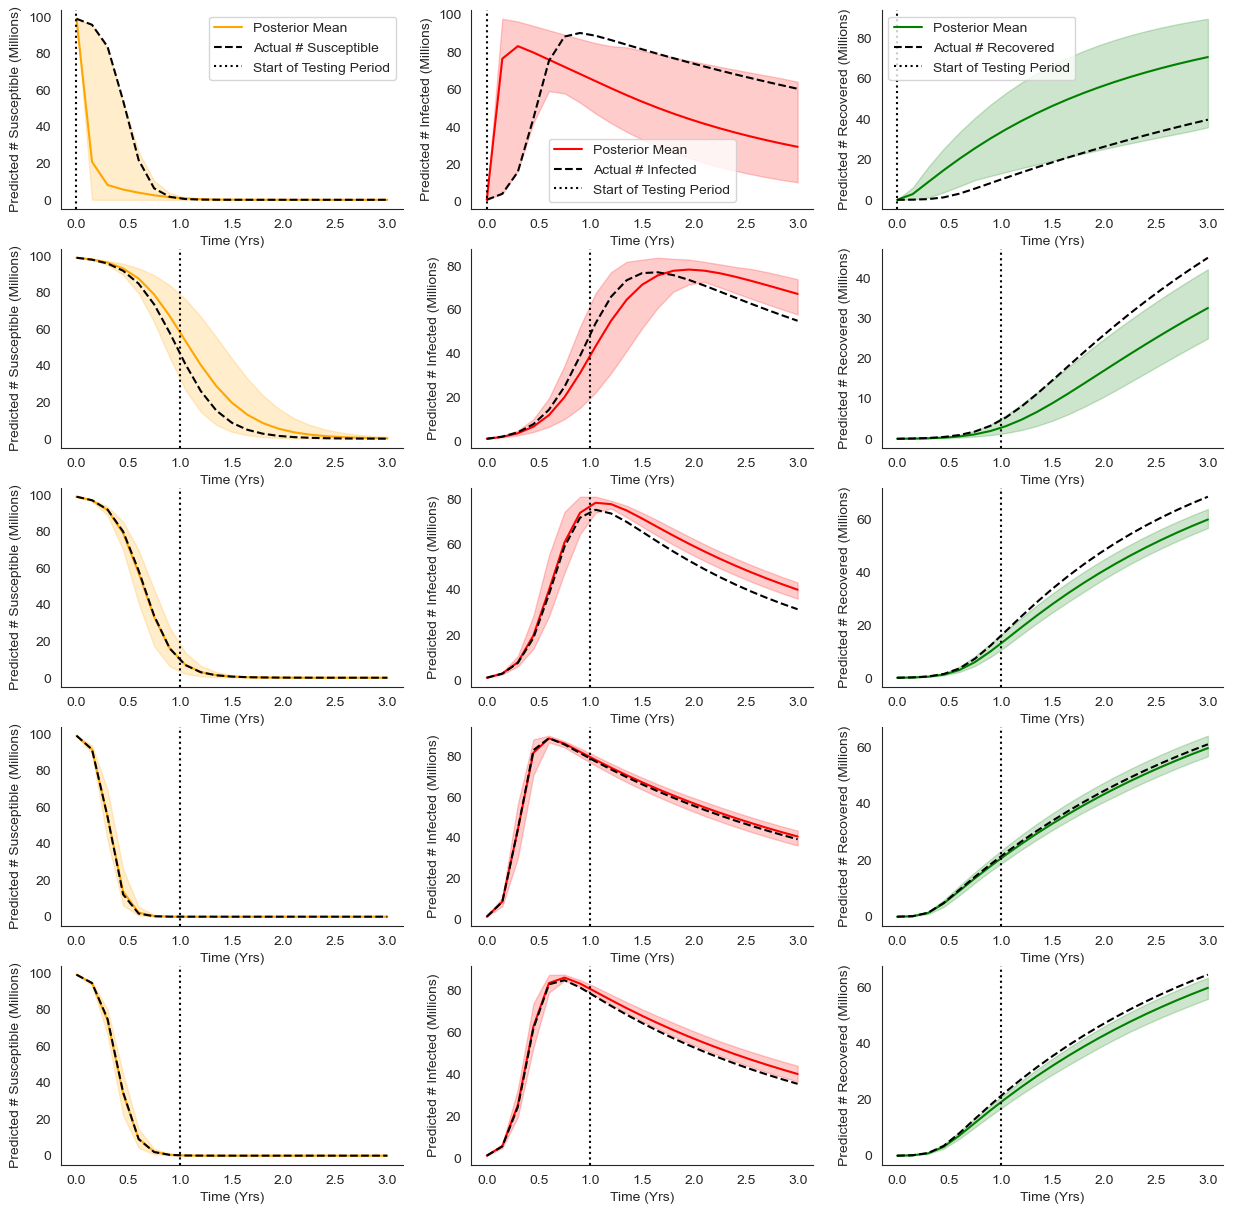

In [35]:
fig, ax = plt.subplots(N_stratum, 3, figsize=(15, 15))

states = ["S", "I", "R"]
colors = ["orange", "red", "green"]
pred_labels = ["Predicted # Susceptible (Millions)", "Predicted # Infected (Millions)", "Predicted # Recovered (Millions)"]
data_labels = ["Actual # Susceptible", "Actual # Infected", "Actual # Recovered"]


for i in range(N_stratum):
    for j, (state, color, pred_label, data_label) in enumerate(zip(states, colors, pred_labels, data_labels)):
        if i == 0:
            test_time = 0.0
            legend = True
        else:
            test_time = 1.
            legend = False
        SIR_plot(time_period, test_time, samples[f"{state}_{i}"], getattr(sir_true_trajs[i], state), pred_label, color, data_label, ax[i, j], legend=legend)


## Pooled Model

In [39]:
beta0_grid.mean()

tensor(0.0990)

In [51]:
def pooling_prior():
    beta0_mean = pyro.sample("beta0_mean", dist.Uniform(.05, .15))
    beta0_var = .05 ** 2 # we don't want think infection rate varies by more than 2.5% between strata
    # Formula relating mean and variance of beta distribution to alpha and beta parameters:
    # https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance
    alpha = ((1 - beta0_mean) / beta0_var - (1 / beta0_mean)) * beta0_mean ** 2
    beta = alpha * (1 / beta0_mean - 1)
    beta0_prior = dist.Beta(alpha, beta)
    gamma_prior = dist.Uniform(0, 1)
    return beta0_prior, gamma_prior

def pooled_multi_level_sir(N_stratum, init_states, tspan):
    beta0_prior, gamma_prior = pooling_prior()
    return multi_level_sir(N_stratum, init_states, tspan, beta0_prior, gamma_prior)

def pooled_conditioned_multi_level_sir(multi_data, init_states, tspan):
    beta0_prior, gamma_prior = pooling_prior()
    return conditioned_multi_level_sir(multi_data, init_states, tspan, beta0_prior, gamma_prior)


In [52]:
b, _ = pooling_prior()

samples = torch.tensor([b() for _ in range(100)])
samples.mean(), samples.std()

(tensor(0.1251), tensor(0.0532))

In [45]:
pooled_multi_guide = AutoMultivariateNormal(pooled_conditioned_multi_level_sir)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(pooled_conditioned_multi_level_sir, pooled_multi_guide, adam, loss=Trace_ELBO())
n_steps = 100

# Do gradient steps
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(multi_data, init_states, torch.tensor([0., 3.])) # need tspan to contain all observation times
    print("[iteration %04d] loss: %.4f" % (step + 1, loss / N_obs))

[iteration 0001] loss: 56.8541
[iteration 0002] loss: 49.3754
[iteration 0003] loss: 58.2694
[iteration 0004] loss: 50.0601
[iteration 0005] loss: 34.3215
[iteration 0006] loss: 60.2219
[iteration 0007] loss: 51.2849
[iteration 0008] loss: 36.0113
[iteration 0009] loss: 38.4529
[iteration 0010] loss: 46.9148
[iteration 0011] loss: 33.0936
[iteration 0012] loss: 36.8091
[iteration 0013] loss: 28.5365
[iteration 0014] loss: 32.1395
[iteration 0015] loss: 29.9194
[iteration 0016] loss: 33.3509
[iteration 0017] loss: 28.6991
[iteration 0018] loss: 26.0192
[iteration 0019] loss: 26.3582
[iteration 0020] loss: 26.2960
[iteration 0021] loss: 29.8281
[iteration 0022] loss: 25.4890
[iteration 0023] loss: 25.6825
[iteration 0024] loss: 25.6763
[iteration 0025] loss: 28.0449
[iteration 0026] loss: 25.7764
[iteration 0027] loss: 26.0373
[iteration 0028] loss: 25.3031
[iteration 0029] loss: 25.6887
[iteration 0030] loss: 26.7138
[iteration 0031] loss: 27.3648
[iteration 0032] loss: 28.4710
[iterati

In [62]:
# Generate samples from the posterior predictive distribution
pooled_predictive = Predictive(pooled_multi_level_sir, guide=pooled_multi_guide, num_samples=50)
pooled_samples = pooled_predictive(N_stratum, init_states, time_period)

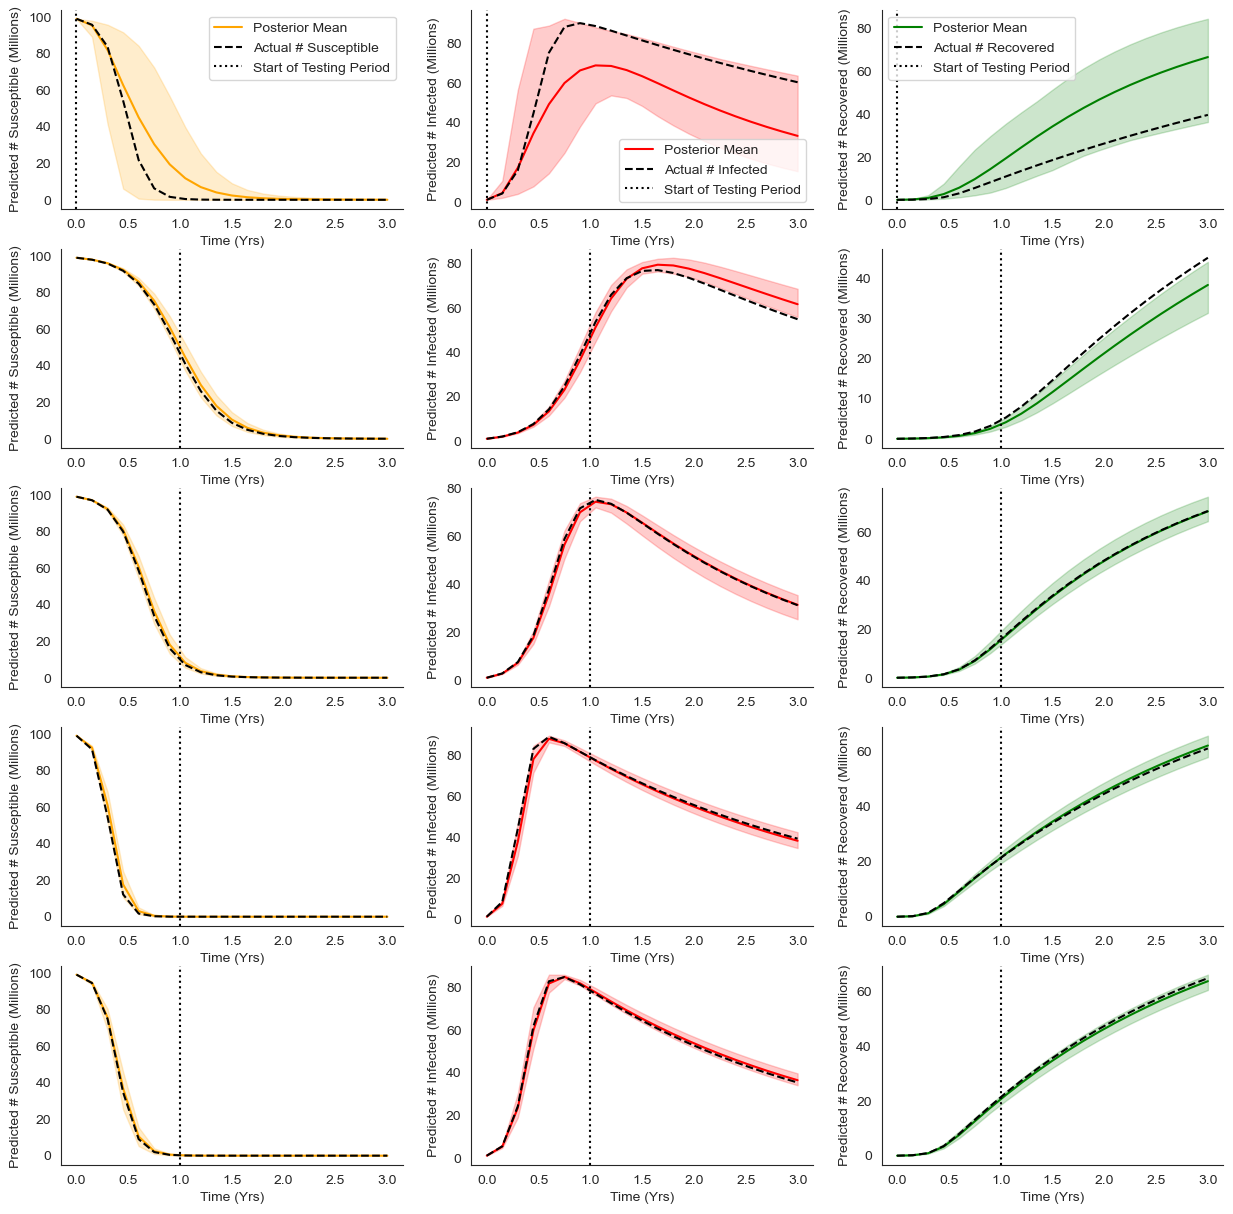

In [63]:
# Plot predicted values for S, I, and R with uncertainty bands (+/- 2 std. devs.)

fig, ax = plt.subplots(N_stratum, 3, figsize=(15, 15))

states = ["S", "I", "R"]
colors = ["orange", "red", "green"]
pred_labels = ["Predicted # Susceptible (Millions)", "Predicted # Infected (Millions)", "Predicted # Recovered (Millions)"]
data_labels = ["Actual # Susceptible", "Actual # Infected", "Actual # Recovered"]


for i in range(N_stratum):
    for j, (state, color, pred_label, data_label) in enumerate(zip(states, colors, pred_labels, data_labels)):
        if i == 0:
            test_time = 0.0
            legend = True
        else:
            test_time = 1.
            legend = False
        SIR_plot(time_period, test_time, pooled_samples[f"{state}_{i}"], getattr(sir_true_trajs[i], state), pred_label, color, data_label, ax[i, j], legend=legend)

# References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan
2. https://benjaminmoll.com/wp-content/uploads/2020/05/SIR_notes.pdf